## Graph Attention Network

* Найти графовый набор данных для решения задачи предсказания (классификация вершин, обнаружение сообществ и т.д.).

* Использовать несколько слоев ```GATConv``` из библиотеки PyG для построения GAT модели.
Обучить полученную модель, подобрать гиперпараметры (например, learning rate) на валидационной выборке, и оценить качество предсказания на тестовой выборке.

In [ ]:
!pip install torch_geometric

In [6]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
from torch import Tensor
from torch_geometric.nn import GATConv, BatchNorm
import torch.nn.functional as F
import itertools
import torch.nn as nn

import pandas as pd
from tqdm.auto import trange
import numpy as np

In [3]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

Используем граф с цитированиями в медицинских научных статьях.

In [4]:
dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [13]:
class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(1234567)

        self.conv1 = GATConv(num_features, hidden_channels, dropout=0.5)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels, dropout=0.5)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GATConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

num_features = 500
hidden_channels = 64
num_classes = 3

model = GAT(num_features=num_features, hidden_channels=hidden_channels, num_classes=num_classes)

print(model)

GAT(
  (conv1): GATConv(500, 64, heads=1)
  (bn1): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(64, 64, heads=1)
  (bn2): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GATConv(64, 3, heads=1)
)


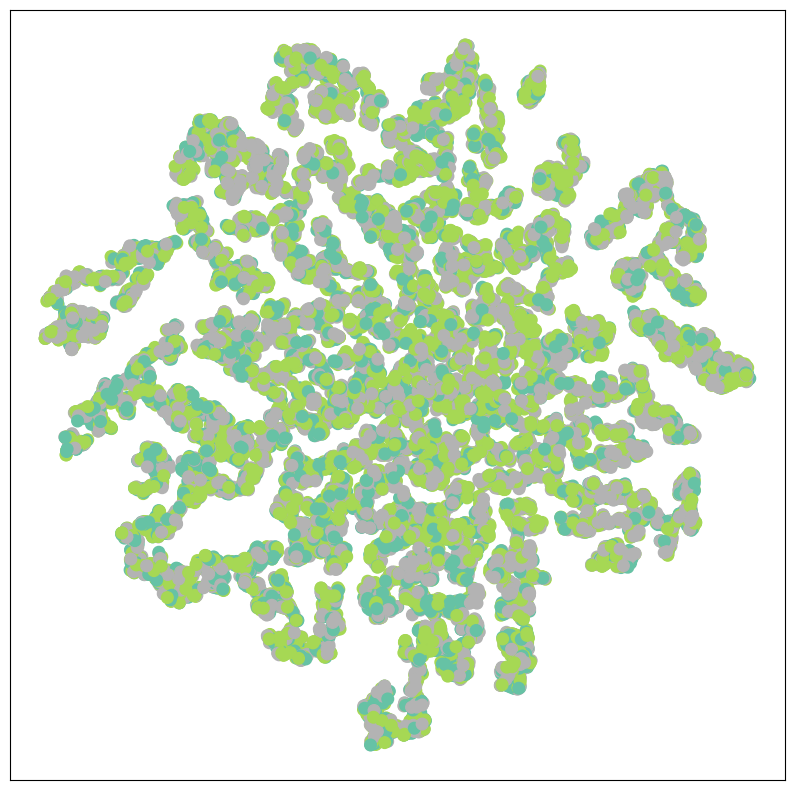

In [8]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [9]:
lrs = [0.1, 0.01, 0.001]
weight_decays = [5e-3, 5e-4, 5e-5]

best_lr = 0
best_weight_decay = 0
max_val_acc = 0

criterion = torch.nn.CrossEntropyLoss()

In [10]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate():
    model.eval()
    out = model(data.x, data.edge_index)
    val_pred = out.argmax(dim=1)
    correct = val_pred[data.val_mask] == data.y[data.val_mask]
    return int(correct.sum()) / int(data.val_mask.sum())

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[data.test_mask] == data.y[data.test_mask]
    return int(correct.sum()) / int(data.test_mask.sum())

In [11]:
for lr, weight_decay in itertools.product(lrs, weight_decays):
    print(f"Training with lr={lr}, weight_decay={weight_decay}")

    model = GAT(num_features=num_features, hidden_channels=hidden_channels, num_classes=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(1, 101):
        train()

    val_acc = validate()
    print(f"Val Accuracy: {val_acc:.4f}")

    if val_acc > max_val_acc:
        max_val_acc = val_acc
        best_lr = lr
        best_weight_decay = weight_decay

print(f"Лучшие гиперпараметры -> lr: {best_lr}, weight_decay: {best_weight_decay}, Val Accuracy: {max_val_acc:.4f}")

Training with lr=0.1, weight_decay=0.005
Val Accuracy: 0.7420
Training with lr=0.1, weight_decay=0.0005
Val Accuracy: 0.6540
Training with lr=0.1, weight_decay=5e-05
Val Accuracy: 0.7220
Training with lr=0.01, weight_decay=0.005
Val Accuracy: 0.7220
Training with lr=0.01, weight_decay=0.0005
Val Accuracy: 0.7600
Training with lr=0.01, weight_decay=5e-05
Val Accuracy: 0.7720
Training with lr=0.001, weight_decay=0.005
Val Accuracy: 0.7900
Training with lr=0.001, weight_decay=0.0005
Val Accuracy: 0.7920
Training with lr=0.001, weight_decay=5e-05
Val Accuracy: 0.7980
Лучшие гиперпараметры -> lr: 0.001, weight_decay: 5e-05, Val Accuracy: 0.7980


In [14]:
model = GAT(num_features=num_features, hidden_channels=hidden_channels, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

for epoch in range(1, 71):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f"Test Accuracy: {test_acc:.4f}")

Epoch: 001, Loss: 1.5804
Epoch: 002, Loss: 1.2131
Epoch: 003, Loss: 1.5453
Epoch: 004, Loss: 1.1097
Epoch: 005, Loss: 1.2215
Epoch: 006, Loss: 1.5131
Epoch: 007, Loss: 1.1733
Epoch: 008, Loss: 0.9885
Epoch: 009, Loss: 1.1101
Epoch: 010, Loss: 0.9553
Epoch: 011, Loss: 0.9249
Epoch: 012, Loss: 0.7819
Epoch: 013, Loss: 0.7796
Epoch: 014, Loss: 0.9203
Epoch: 015, Loss: 0.7272
Epoch: 016, Loss: 0.7208
Epoch: 017, Loss: 0.8116
Epoch: 018, Loss: 0.8032
Epoch: 019, Loss: 0.7072
Epoch: 020, Loss: 0.7420
Epoch: 021, Loss: 0.6582
Epoch: 022, Loss: 0.6673
Epoch: 023, Loss: 0.6918
Epoch: 024, Loss: 0.5655
Epoch: 025, Loss: 0.6144
Epoch: 026, Loss: 0.6732
Epoch: 027, Loss: 0.6776
Epoch: 028, Loss: 0.5934
Epoch: 029, Loss: 0.6174
Epoch: 030, Loss: 0.5398
Epoch: 031, Loss: 0.5199
Epoch: 032, Loss: 0.5343
Epoch: 033, Loss: 0.6028
Epoch: 034, Loss: 0.5921
Epoch: 035, Loss: 0.5232
Epoch: 036, Loss: 0.5235
Epoch: 037, Loss: 0.4771
Epoch: 038, Loss: 0.4965
Epoch: 039, Loss: 0.4707
Epoch: 040, Loss: 0.4960


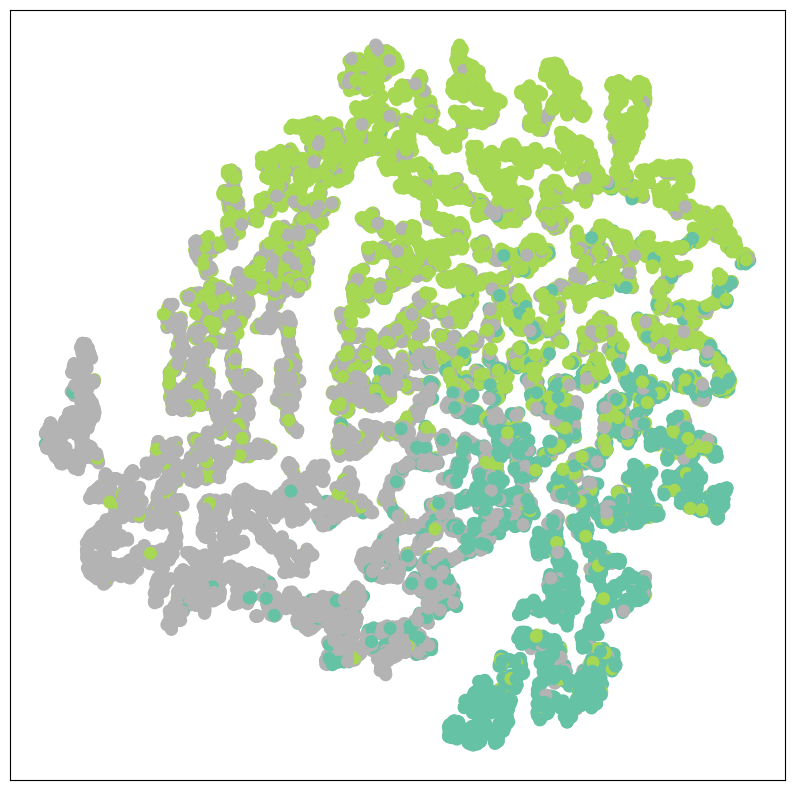

In [15]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

В результате обучения на визуализации выделяются три группы, однако результат немного ниже, чем при использовании GCN слоев (точность на тестовой выборке была равна 0.757)